# [IUM] Dokumentacja wstępna
**Autorzy:**  
Gustaw Malinowski (324872), Kacper Straszak (325234), Aleksandra Szymańska (318733)  
**Data:** 24.11.2024 r.

---

## Oryginalna treść zadania
**Zadanie 10:**  
“Jakiś czas temu wprowadziliśmy konta premium, które uwalniają użytkowników od słuchania reklam. Nie są one jednak jeszcze zbyt popularne – czy możemy się dowiedzieć, które osoby są bardziej skłonne do zakupu takiego konta?”

---

## Analiza z perspektywy Biznesowej

### Opis problemu biznesowego
Naszym celem jest określenie i lepsze zrozumienie profilu osoby skłonnej do zakupu konta premium w oparciu o dane o użytkownikach, ich sesjach użytkowania, artystach, utworach oraz sposobie ich przechowywania zbieranych przez serwis. Na tej podstawie firma będzie mogła podjąć decyzję o strategiach marketingowych skutecznych przy nakłanianiu do zakupu kont premium (personalizacji reklam oraz oferty) i zwiększyć zysk płynący z tego typu oferowanych usług.

---

### Założenia
- Ponieważ klient nie ponosi kosztów, uznajemy, że zwrot z inwestycji w stosunku do kosztów zawsze będzie nieskończony.
- Klient nie dysponuje istniejącym rozwiązaniem, które musielibyśmy "pokonać".
- Model nie musi być interpretowalny, ponieważ klient nie ma możliwości wpływania na zachowania użytkownika wpływające na zakup konta premium, takie jak średni czas słuchania muzyki na sesję.
- Zakładamy zdroworozsądkowe ograniczenia dotyczące prędkości obliczeń (czas obliczeń dla pojedynczego użytkownika nie powinien być zauważalny).

---

### Wymagania klienta
Od strony zastosowań biznesowych klient nie ma jasno sprecyzowanych wymagań. Oczekuje jedynie rozwiązania, które umożliwi mu dostosowanie rekomendacji.  

**Główne wymagania:**
- Dostarczenie gotowego rozwiązania maksymalnie do 17.01.2025.
- Rozwiązanie w postaci mikroserwisu umożliwiającego łatwe wykorzystanie modelu w produkcji.
- Dostarczenie dwóch modeli oraz porównanie ich wyników.
- Wykonanie eksperymentu A/B porównującego dwa modele.

---

### Proponowane biznesowe kryteria sukcesu
Rozwiązanie pozwoli klientowi zwiększyć liczbę zakupów kont premium poprzez precyzyjniejsze targetowanie reklam, zamiast dotychczasowego szerokiego serwowania ich do wszystkich użytkowników.

---

## Analiza z perspektywy modelowania

### Zadanie Modelowania

#### Analiza zadania
Aby zrealizować zadanie biznesowe polegające na określeniu użytkowników skłonnych do zakupu konta premium, definiujemy problem jako klasyfikację – czy użytkownik kupił konto premium, czy nie. Celem jest stworzenie modelu klasyfikacyjnego, który na podstawie danych o użytkownikach pozwala przewidzieć, czy dany użytkownik jest skłonny do zakupu konta premium.

---

#### Analityczne kryterium sukcesu
Model będzie miał większą dokładność niż najprostszy model bazowy. Za cel przyjmujemy dokładność na poziomie 60%.

---

#### Analityczne miary jakości modelu
W trakcie modelowania planujemy wykorzystać: 
1. Macierz Pomyłek  
2. Precyzję modelu  
3. Dokładność klasyfikacji  
4. Wartość F1  

---

### Analiza Danych

#### Dane dostarczone przez klienta
Klient dostarczył nam następujące dane:
- Ulubione gatunki muzyczne użytkowników.
- Miejsce zamieszkania użytkowników.
- Logi interakcji użytkowników z serwisem.
- Baza artystów z uwzględnieniem ich stylów muzycznych.
- Baza utworów wraz z ich charakterystyką i typem przechowywania.

---

#### Dostępne i wygenerowane atrybuty
Na podstawie dostarczonych danych zdefiniowaliśmy następujące atrybuty:
- Ilość wysłuchanych piosenek
- Średnia ilość wysłuchanych piosenek w sesji
- Ilość sesji
- Skip rate na sesje
- Czas słuchania w serwisie
- Czas słuchania w miesiącu
- Średni czas słuchania dzienny
- Czas słuchania w jednej sesji
- Ilość polubionych piosenek na wysłuchane

---

#### Liczba próbek

In [2]:
#%pip install pandas
#%pip install numpy
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = 'content/artists.jsonl'
artists = pd.read_json(file_path, lines=True, encoding='utf-8')
file_path = 'content/sessions.jsonl'
sessions = pd.read_json(file_path, lines=True, encoding='utf-8')
file_path = 'content/track_storage.jsonl'
track_storage = pd.read_json(file_path, lines=True, encoding='utf-8')
file_path = 'content/tracks.jsonl'
tracks = pd.read_json(file_path, lines=True, encoding='utf-8')
file_path = 'content/users.jsonl'
users = pd.read_json(file_path, lines=True, encoding='utf-8')

data = ['artists', 'sessions', 'track_storage', 'tracks', 'users']

for variable in data:
	dataset = globals()[variable]
	if variable == 'artists':
		dataset['genres'] = dataset['genres'].apply(lambda x: str(x) if isinstance(x, list) else x)
	elif variable == 'users':
		dataset['favourite_genres'] = dataset['favourite_genres'].apply(lambda x: str(x) if isinstance(x, list) else x)
	print(f"\nAnalyzing {variable}")
	print(f"Number of samples: {dataset.shape[0]}")
	print(f"Number of atributes: {dataset.shape[1]}")
	print(f"Included information: {list(dataset.columns)}")
	print(f"Unique atribute values: {list(dataset.nunique())}")


Analyzing artists
Number of samples: 27650
Number of atributes: 3
Included information: ['id', 'name', 'genres']
Unique atribute values: [27650, 27542, 13704]

Analyzing sessions
Number of samples: 1453169
Number of atributes: 5
Included information: ['timestamp', 'user_id', 'track_id', 'event_type', 'session_id']
Unique atribute values: [1211579, 3000, 11291, 5, 37694]

Analyzing track_storage
Number of samples: 129648
Number of atributes: 3
Included information: ['track_id', 'storage_class', 'daily_cost']
Unique atribute values: [129648, 3, 47797]

Analyzing tracks
Number of samples: 129648
Number of atributes: 19
Included information: ['id', 'artist_id', 'name', 'popularity', 'duration_ms', 'explicit', 'release_date', 'danceability', 'energy', 'key', 'mode', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
Unique atribute values: [129648, 27650, 114383, 96, 46964, 2, 14915, 1026, 1873, 12, 2, 20416, 1640, 4566, 5400, 1

Dla każdego z pięciu dostarczonych zbiorów danych przeprowadziliśmy analizę liczby próbek, atrybutów oraz unikalnych wartości dla każdego atrybutu. Dane charakteryzują się dużą różnorodnością i obszernością, co stanowi solidną podstawę do analizy oraz trenowania modeli klasyfikacyjnych. Szczególną uwagę będziemy skupiać na zbiorze danych o użytkownikach, który zawiera informacje o kontach premium, oraz na największym zbiorze dotyczącym sesji użytkowników. Pozostałe zbiory, takie jak dane o utworach, artystach i ich przechowywaniu, będą stanowiły wartościowe uzupełnienie, dostarczając dodatkowego kontekstu i informacji o preferencjach.

---

#### Jakość danych
**Powtórzenia wartości**  

In [26]:
for variable in data:
	dataset = globals()[variable]
	duplicated = dataset.duplicated().sum()
	if variable == 'sessions':
		duplicated_ids = dataset['session_id'].duplicated().sum()
	elif variable == 'track_storage':
		duplicated_ids = dataset['track_id'].duplicated().sum()
	elif variable == 'users':
		duplicated_ids = dataset['user_id'].duplicated().sum()
	else:
		duplicated_ids = dataset['id'].duplicated().sum()
	print(f"\nAnalyzing {variable}")
	print(f"Duplicated entries: {duplicated}")
	print(f"Duplicated ids: {duplicated_ids}")


Analyzing artists
Duplicated entries: 0
Duplicated ids: 0

Analyzing sessions
Duplicated entries: 0
Duplicated ids: 1415475

Analyzing track_storage
Duplicated entries: 0
Duplicated ids: 0

Analyzing tracks
Duplicated entries: 0
Duplicated ids: 0

Analyzing users
Duplicated entries: 0
Duplicated ids: 0


Dane nie zawierają istotnych duplikatów. Powtarzające id sesji nas nie martwią, bo w każdej sesji mogło być zarejestrowane wiele akcji użytkownika.


**Brakujące wartości**

In [28]:
for variable in data:
	dataset = globals()[variable]
	dataset.replace("", np.nan, inplace=True)
	print(f"\n\nAnalyzing {variable}")
	null = dataset.isnull().sum()
	print(f"NULL values summed: {null.sum()}")
	print(f"NULL values atributes: {null[null > 0].index.tolist()}")
	print(f"NULL values: {null[null > 0].tolist()}")
	print(f"NULL values percent: {((null[null > 0] / dataset.shape[0]) * 100).tolist()}")



Analyzing artists
NULL values summed: 0
NULL values atributes: []
NULL values: []
NULL values percent: []


Analyzing sessions
NULL values summed: 192781
NULL values atributes: ['track_id']
NULL values: [192781]
NULL values percent: [13.266247766089148]


Analyzing track_storage
NULL values summed: 0
NULL values atributes: []
NULL values: []
NULL values percent: []


Analyzing tracks
NULL values summed: 103718
NULL values atributes: ['mode']
NULL values: [103718]
NULL values percent: [79.99969147229422]


Analyzing users
NULL values summed: 0
NULL values atributes: []
NULL values: []
NULL values percent: []


W sesjach czasem brakuje informacji o id utworu - nie jest to problemem, bo występuje to przy odtwarzaniu reklamy, wtedy "track_id" nie jest zapisywany. Niektórym utworom brakuje wartości o tonalności ("mode"). Jesteśmy sobie w stanie wyobrazić, że niektóre utwory nie mogą zostać zakwalifikowane do tonacji dur, czy mol. Zaobserwowaliśmy, że dzieje się tak np.: w przypadku "ebooka" występującego w częściach "Das verkaufte Bett - Teil 10".

---

#### Reprezentatywność atrybutów

Dla users

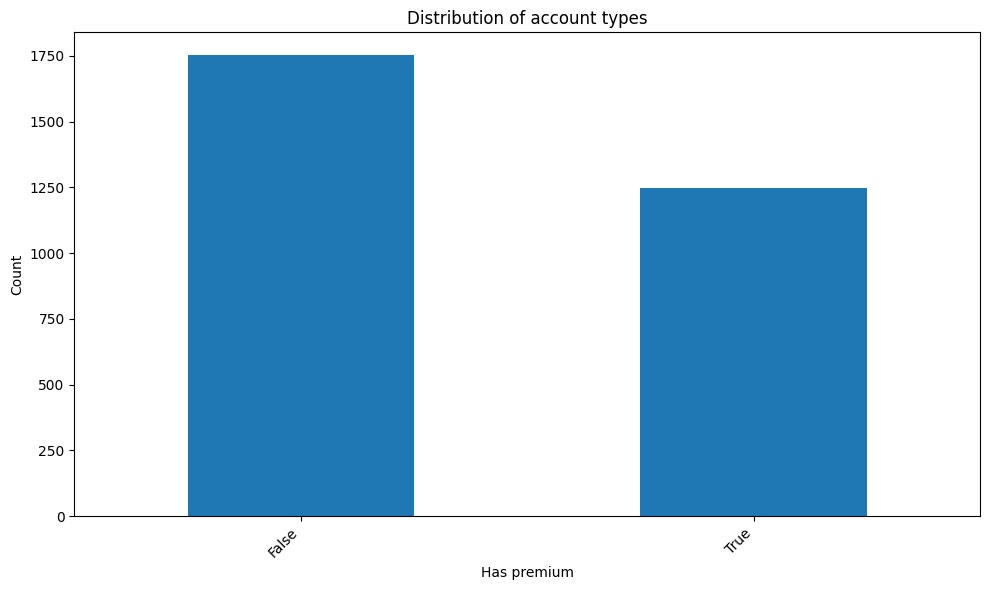

In [ ]:
file_path = 'content/artists.jsonl'
artists = pd.read_json(file_path, lines=True, encoding='utf-8')

file_path = 'content/users.jsonl'
with open(file_path, 'r', encoding='utf-8') as file:
    users = [json.loads(line) for line in file]

genre_counter = {}
for genres in artists['genres']:
    for genre in genres:
        genre_counter[genre] = genre_counter.get(genre, 0) + 1

user_counter = {}
for user in users:
    for genre in user.get('favourite_genres', []):
        if genre not in user_counter:
            user_counter[genre] = [0, 0]  # [total_users, premium_users]
        user_counter[genre][0] += 1
        if user.get('premium_user', False):
            user_counter[genre][1] += 1

file_path = 'content/users.jsonl'
users_df = pd.read_json(file_path, lines=True, encoding='utf-8')
users_premium_counts = users_df['premium_user'].value_counts()

plt.figure(figsize=(10, 6))
users_premium_counts.plot(kind='bar')
plt.title("Distribution of account types")
plt.ylabel("Count")
plt.xlabel("Has premium")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

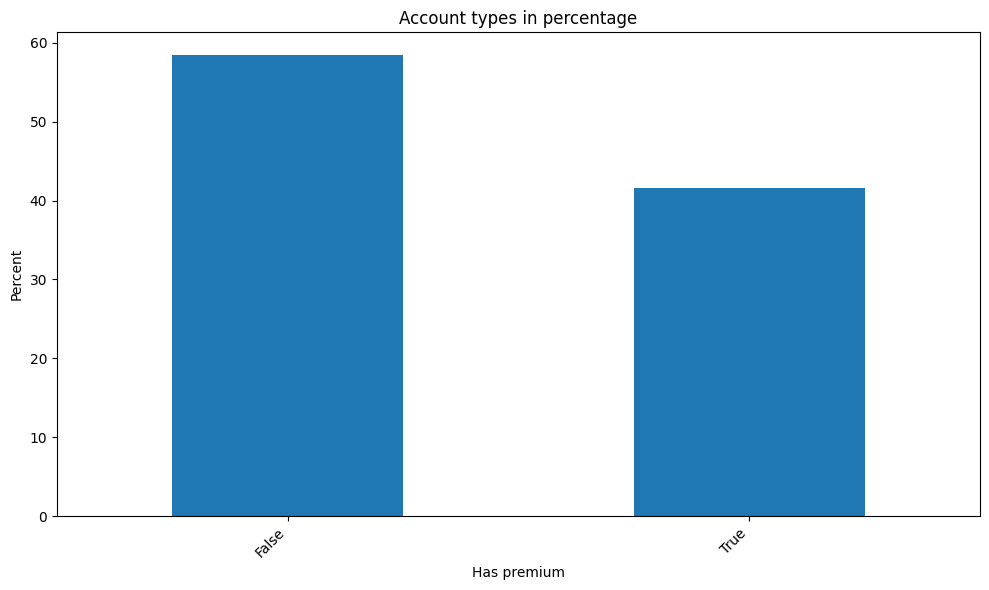

In [10]:
percentages = (users_premium_counts / users_premium_counts.sum()) * 100

plt.figure(figsize=(10, 6))
percentages.plot(kind='bar')
plt.title("Account types in percentage")
plt.ylabel("Percent")
plt.xlabel("Has premium")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Użytkownicy premium są w klasie mniejszościowej, ale stanowią znaczącą część wszystkich użytkowników (40% w porównaniu do 60% użytkowników nie-premium). 

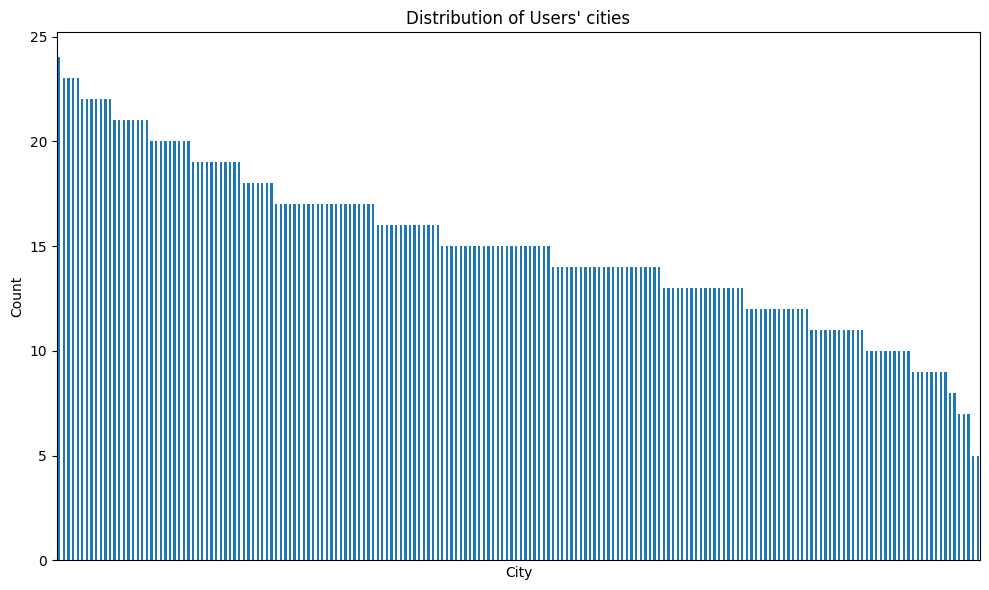

In [30]:
file_path = 'content/users.jsonl'
users_df = pd.read_json(file_path, lines=True, encoding='utf-8')
user_city_counts = users_df['city'].value_counts()

plt.figure(figsize=(10, 6))
user_city_counts.plot(kind='bar')
plt.title("Distribution of Users' cities")
plt.ylabel("Count")
plt.xlabel("City")
plt.xticks([])
plt.tight_layout()
plt.show()

W niektórych miastach jest więcej użytkowników, ale liczba użtkowników 

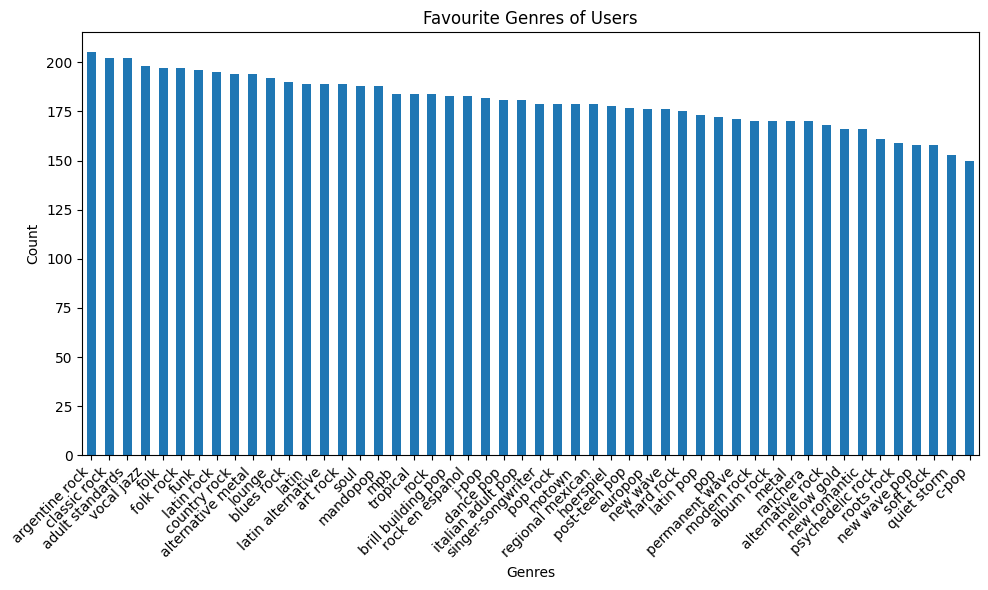

In [31]:
favourite_genres_flat = [genre for sublist in users_df['favourite_genres'] for genre in sublist]

genre_counts_users = pd.Series(favourite_genres_flat).value_counts()

plt.figure(figsize=(10, 6))
genre_counts_users.plot(kind='bar')
plt.title("Favourite Genres of Users")
plt.ylabel("Count")
plt.xlabel("Genres")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


dla artists

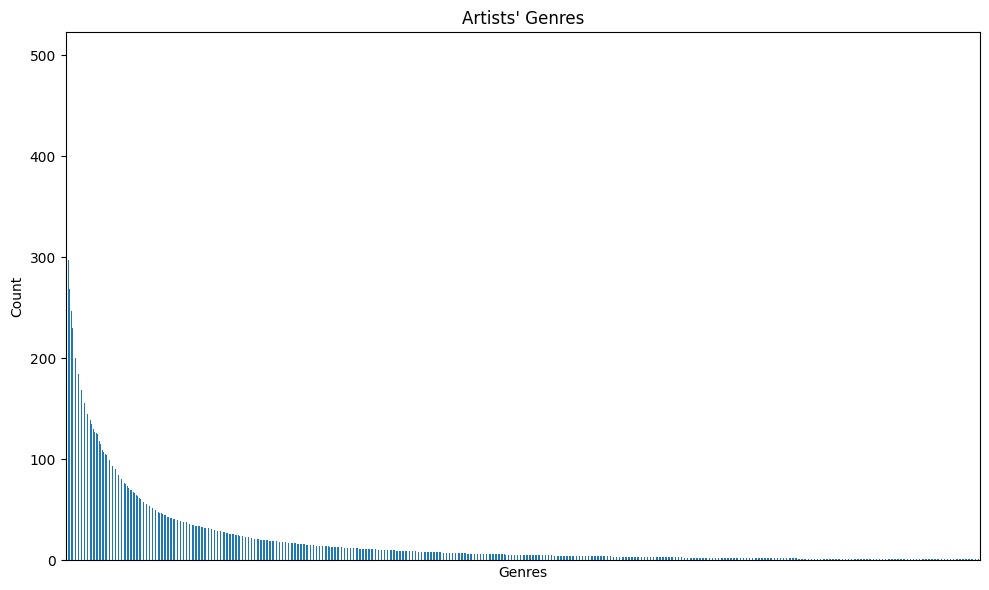

In [32]:
genres_flat = [genre for sublist in artists['genres'] for genre in sublist]

genre_counts_users = pd.Series(genres_flat).value_counts()

plt.figure(figsize=(10, 6))
genre_counts_users.plot(kind='bar')
plt.title("Artists' Genres")
plt.ylabel("Count")
plt.xlabel("Genres")
plt.xticks([])
plt.tight_layout()
plt.show()


dla sessions

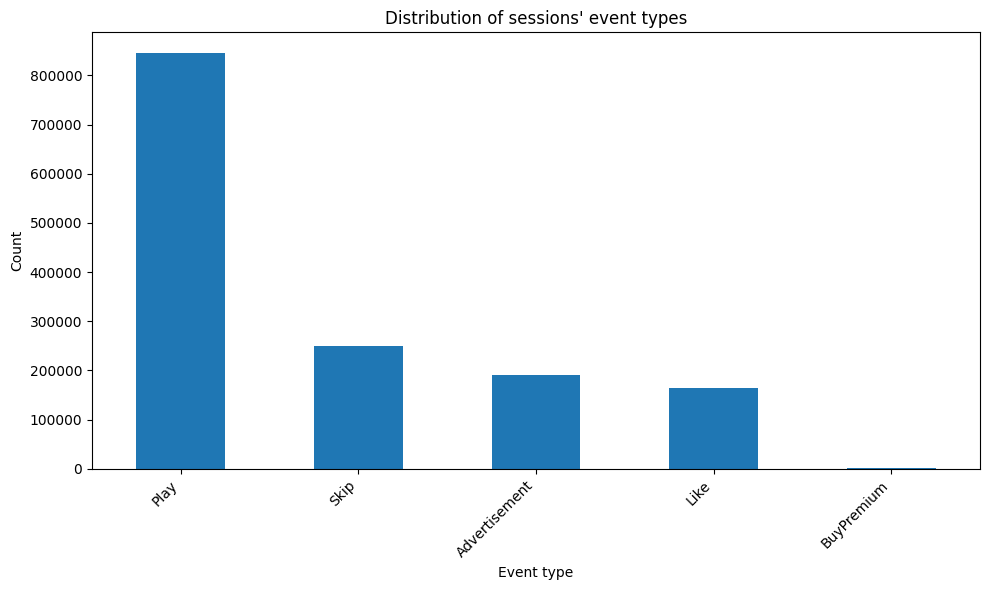

In [33]:
sessions_event_type_counts = sessions['event_type'].value_counts()

plt.figure(figsize=(10, 6))
sessions_event_type_counts.plot(kind='bar')
plt.title("Distribution of sessions' event types")
plt.ylabel("Count")
plt.xlabel("Event type")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

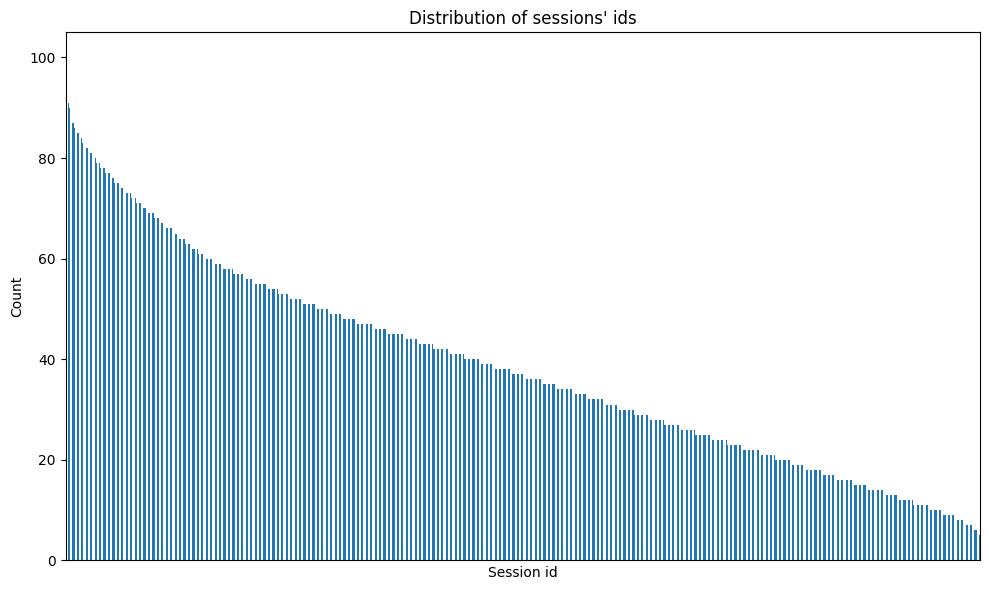

In [34]:
session_id_counts = sessions['session_id'].value_counts()

plt.figure(figsize=(10, 6))
session_id_counts.plot(kind='bar')
plt.title("Distribution of sessions' ids")
plt.ylabel("Count")
plt.xlabel("Session id")
plt.xticks([])
plt.tight_layout()
plt.show()

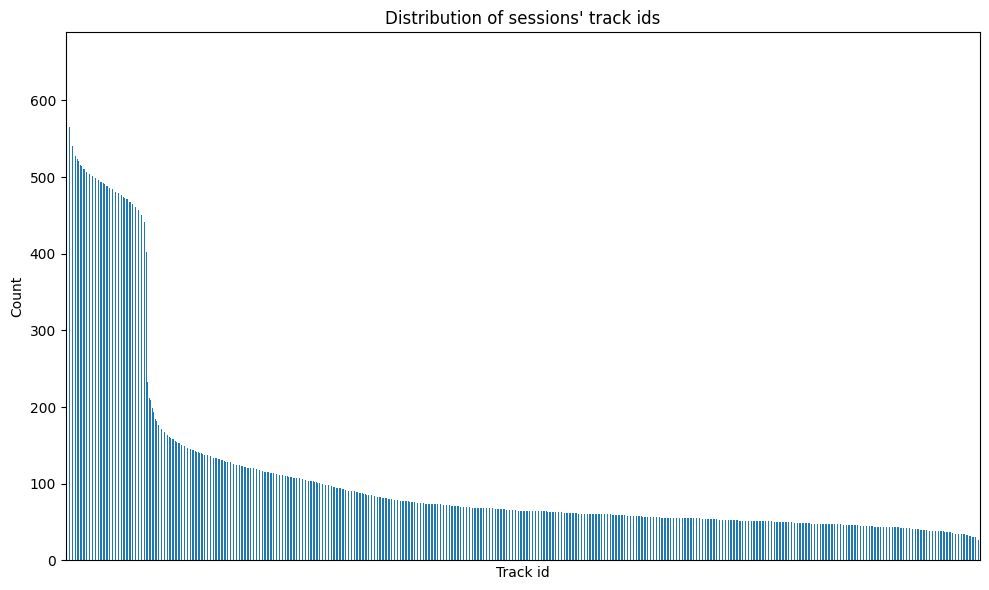

In [35]:
session_user_id_counts = sessions['track_id'].value_counts()

plt.figure(figsize=(10, 6))
session_user_id_counts.plot(kind='bar')
plt.title("Distribution of sessions' track ids")
plt.ylabel("Count")
plt.xlabel("Track id")
plt.xticks([])
plt.tight_layout()
plt.show()

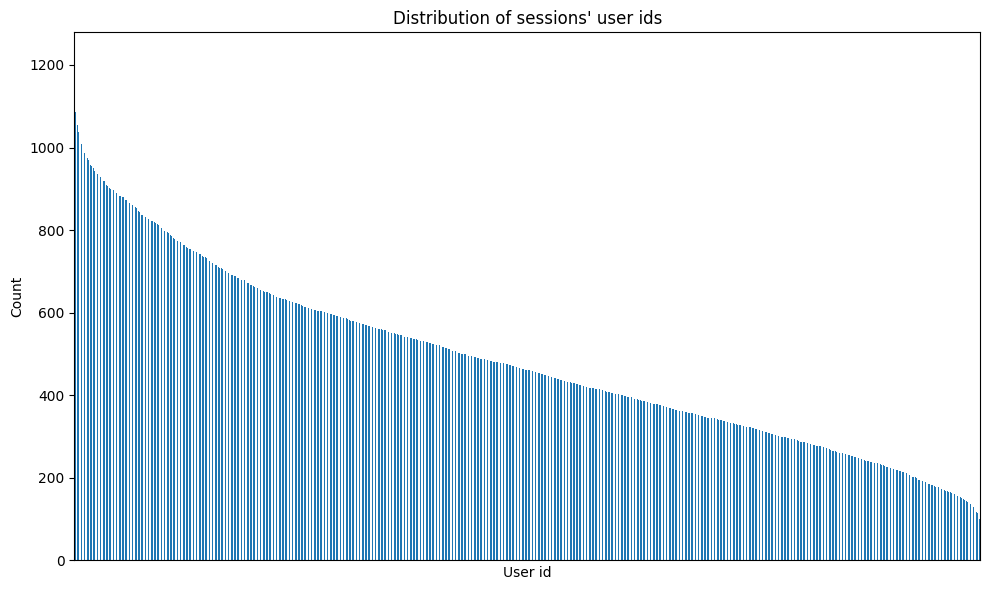

In [36]:
session_user_id_counts = sessions['user_id'].value_counts()

plt.figure(figsize=(10, 6))
session_user_id_counts.plot(kind='bar')
plt.title("Distribution of sessions' user ids")
plt.ylabel("Count")
plt.xlabel("User id")
plt.xticks([])
plt.tight_layout()
plt.show()

dla tracks

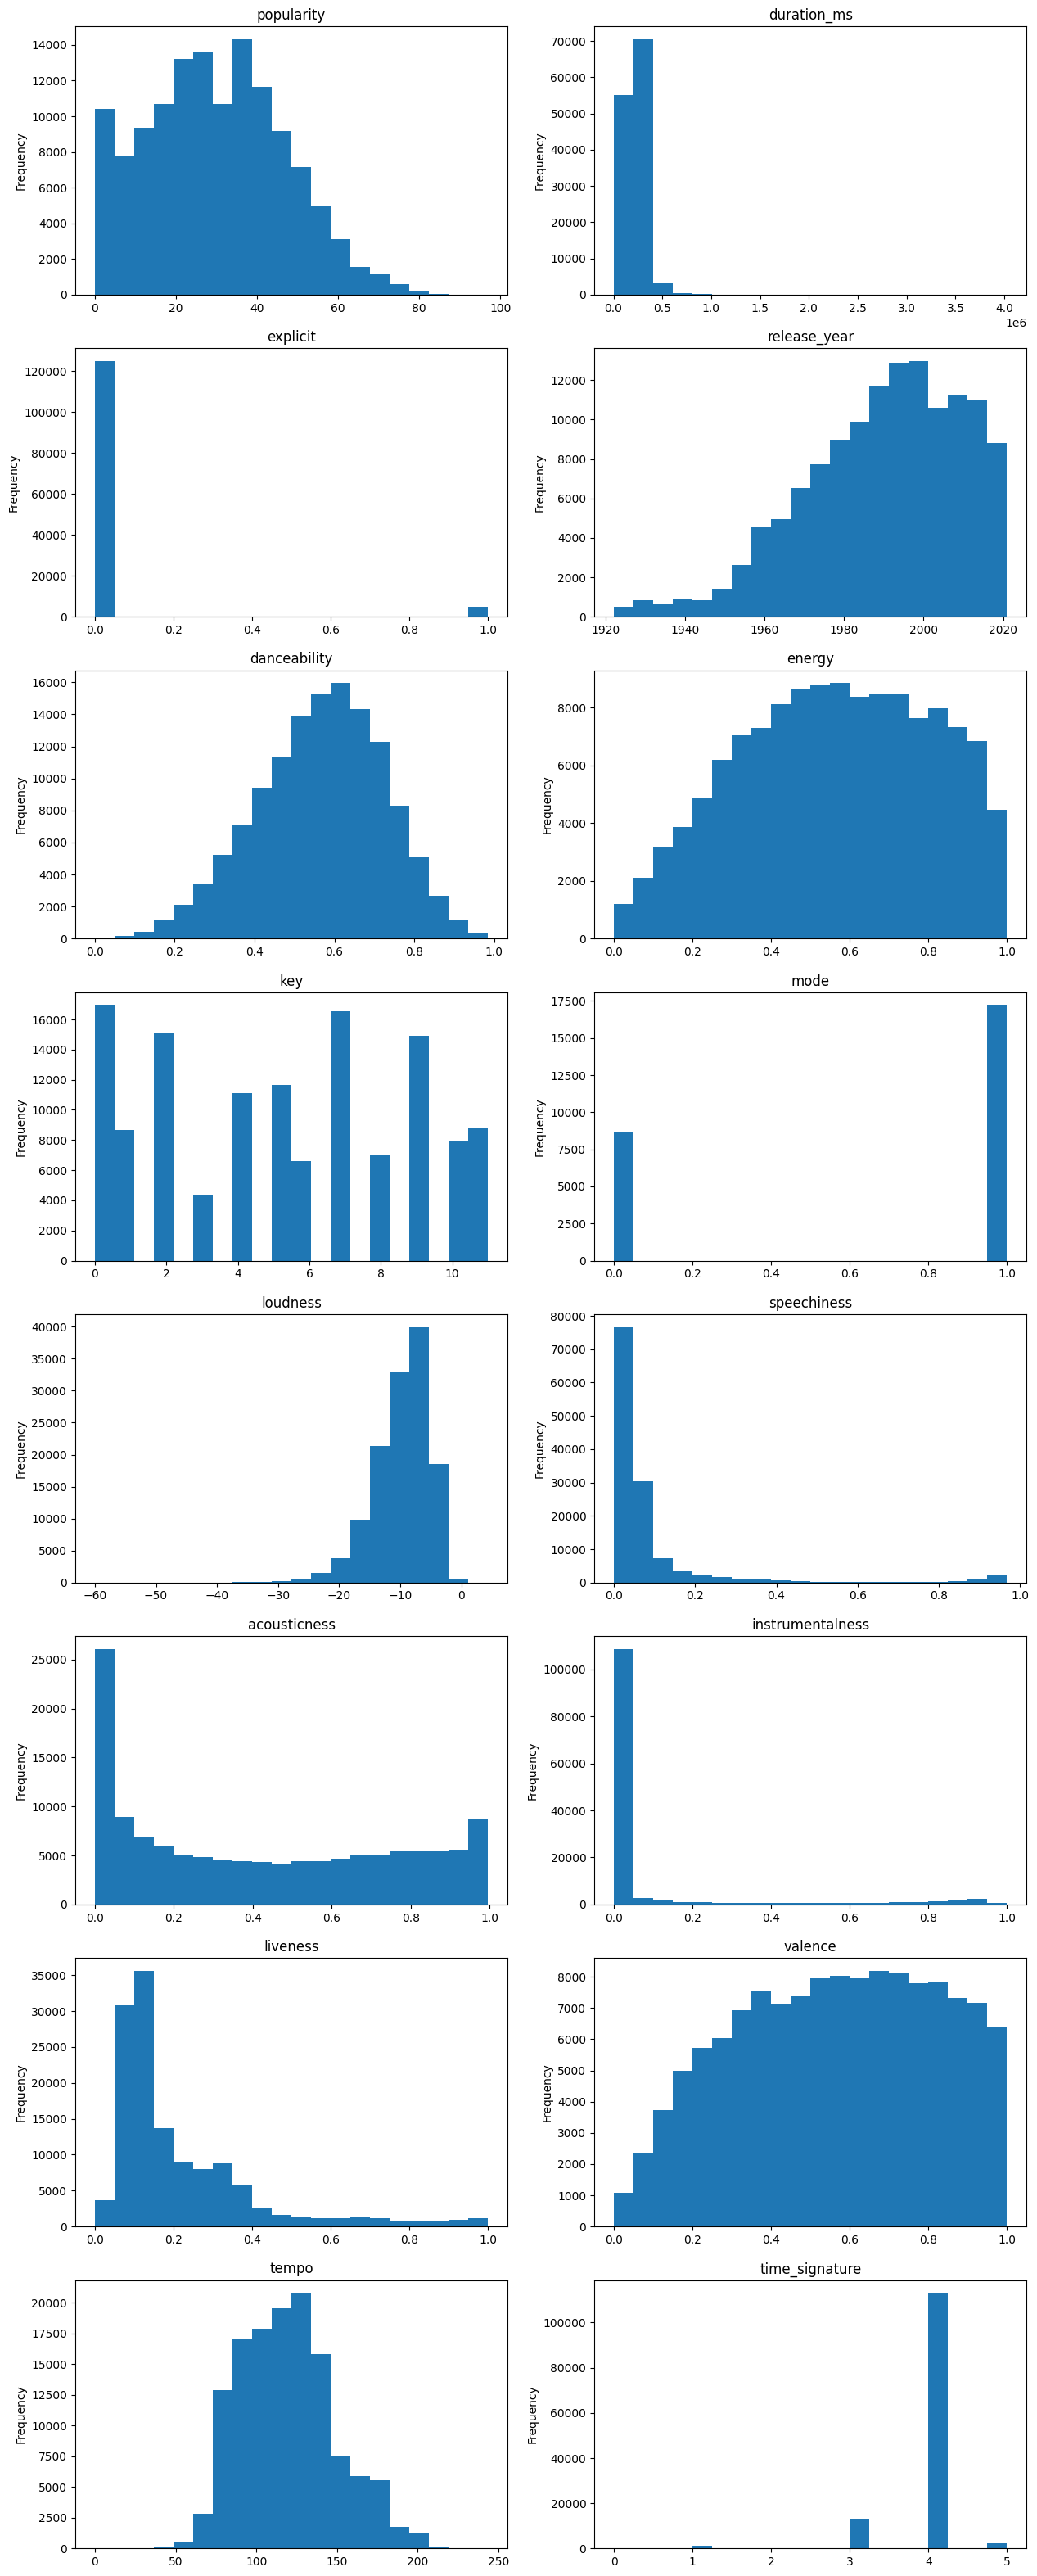

In [37]:
tracks['release_year'] = tracks['release_date'].str[:4].astype(int) 
#okazało się, że część danych w tej kolumnie to sam rok, a część ma też miesiac i dzień po myślniku

X = tracks[[#'id', 'artist_id', 'name',
    'popularity', 'duration_ms', 'explicit', #'release_date',
    'release_year', 'danceability', 'energy', 'key', 'mode', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'time_signature']]

n_attributes = len(X.keys())

n_cols = 2  
n_rows = (n_attributes // n_cols) + (n_attributes % n_cols > 0)  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

axes = axes.flatten()

for idx, (x, ax) in enumerate(zip(X.keys(), axes)):
    X[x].plot(kind="hist", bins=20, ax=ax)
    ax.set_title(f"{x}")
    # ax.set_xlabel(x) 
    ax.set_ylabel('Frequency')  

for idx in range(n_attributes, len(axes)):
    axes[idx].axis('off')

plt.show()


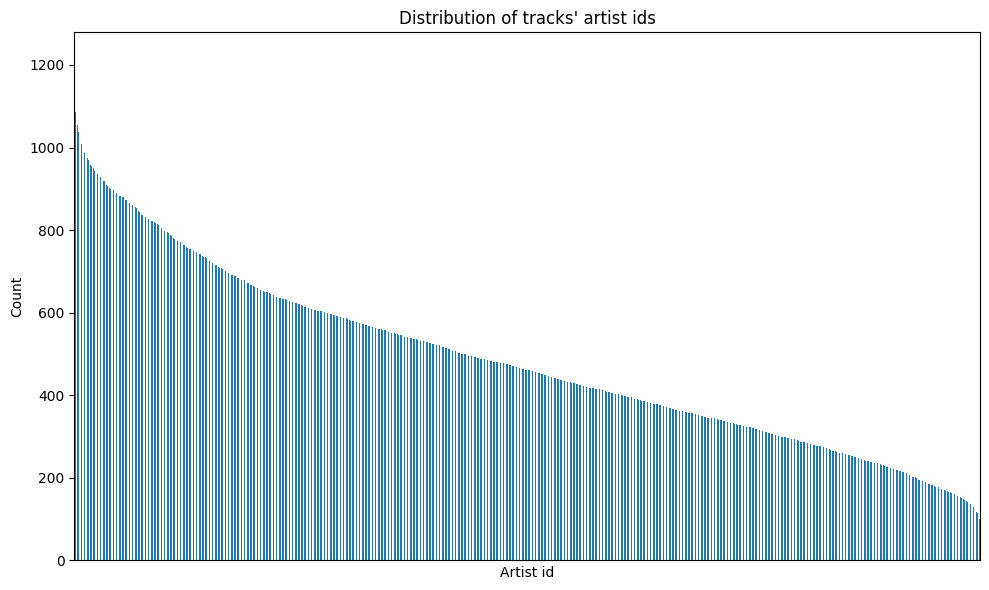

In [38]:
tracks_artist_id_counts = tracks['artist_id'].value_counts()

plt.figure(figsize=(10, 6))
session_user_id_counts.plot(kind='bar')
plt.title("Distribution of tracks' artist ids")
plt.ylabel("Count")
plt.xlabel("Artist id")
plt.xticks([])
plt.tight_layout()
plt.show()

dla tracks_storage

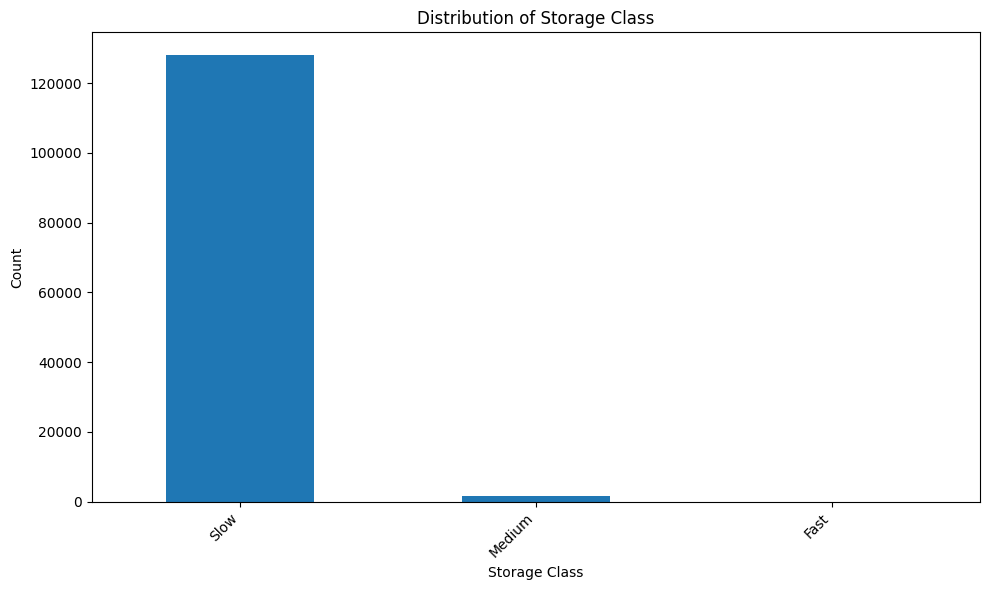

In [39]:
storage_class_counts = track_storage['storage_class'].value_counts()

plt.figure(figsize=(10, 6))
storage_class_counts.plot(kind='bar')
plt.title("Distribution of Storage Class")
plt.ylabel("Count")
plt.xlabel("Storage Class")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---

#### Informatywność atrybutów

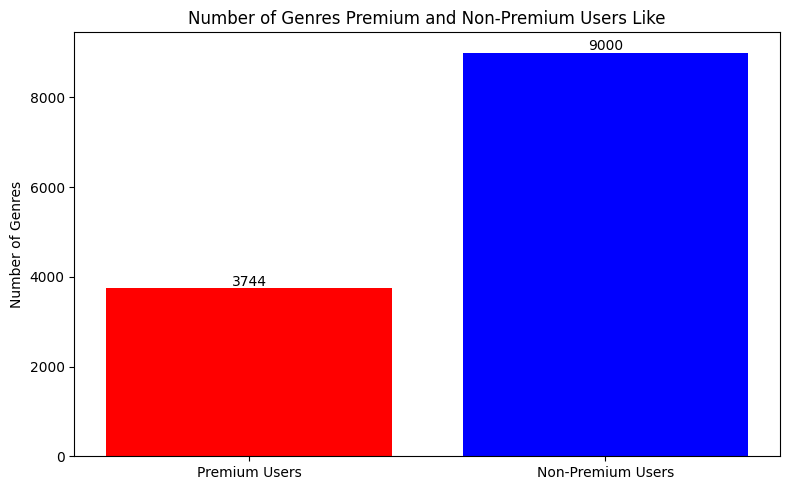

In [7]:


total_premium_users = sum(value[1] for value in user_counter.values())
total_non_premium_users = sum(value[0] for value in user_counter.values())

# Przygotuj dane do wykresu
categories = ['Premium Users', 'Non-Premium Users']
user_counts = [total_premium_users, total_non_premium_users]

# Rysowanie wykresu
plt.figure(figsize=(8, 5))
plt.bar(categories, user_counts, color=['red', 'blue'])

# Dodanie opisu osi i tytułu
plt.ylabel('Number of Genres')
plt.title('Number of Genres Premium and Non-Premium Users Like')

# Wyświetlenie wartości na słupkach
for i, count in enumerate(user_counts):
    plt.text(i, count + 50, str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

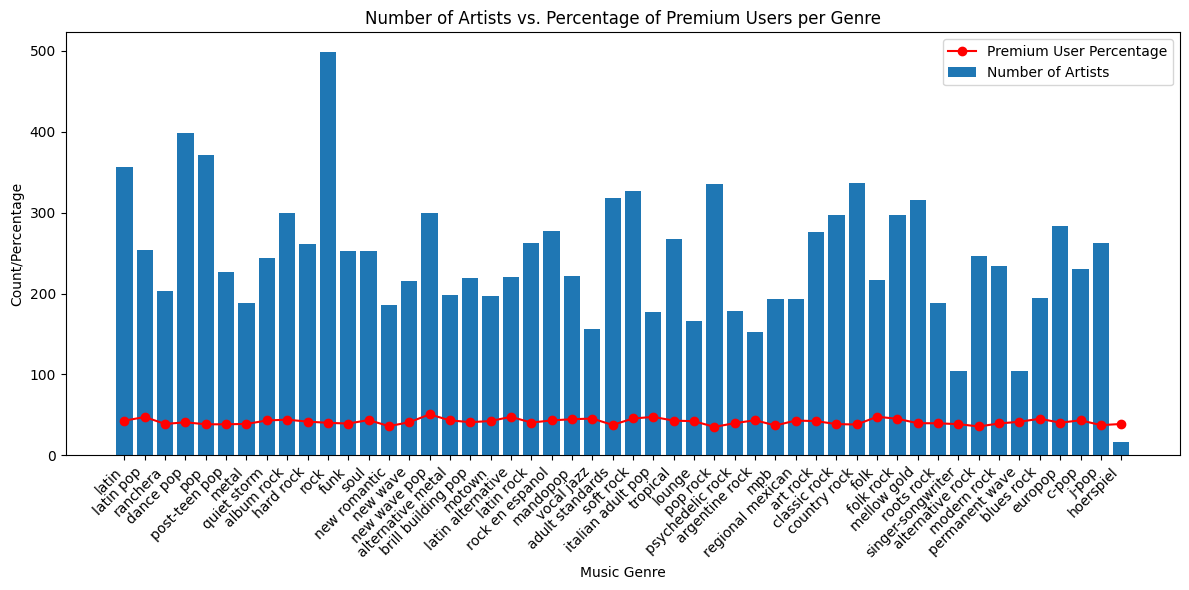

In [40]:
for genre, counts in user_counter.items():
    total_users, premium_users = counts
    user_counter[genre] = [premium_users, premium_users / total_users]

genres = list(genre_counter.keys())
gg = genres.copy()
num_bands = list(genre_counter.values())
premium_percentage = []
for genre in gg:
  if genre in user_counter:
    premium_percentage.append(user_counter[genre][1] * 100)
  else:
    num_bands.pop(genres.index(genre))
    genres.remove(genre)

plt.figure(figsize=(12, 6))
plt.bar(genres, num_bands, label='Number of Artists')
plt.plot(genres, premium_percentage, marker='o', color='red', label='Premium User Percentage')

plt.xlabel('Music Genre')
plt.ylabel('Count/Percentage')
plt.title('Number of Artists vs. Percentage of Premium Users per Genre')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()
print()

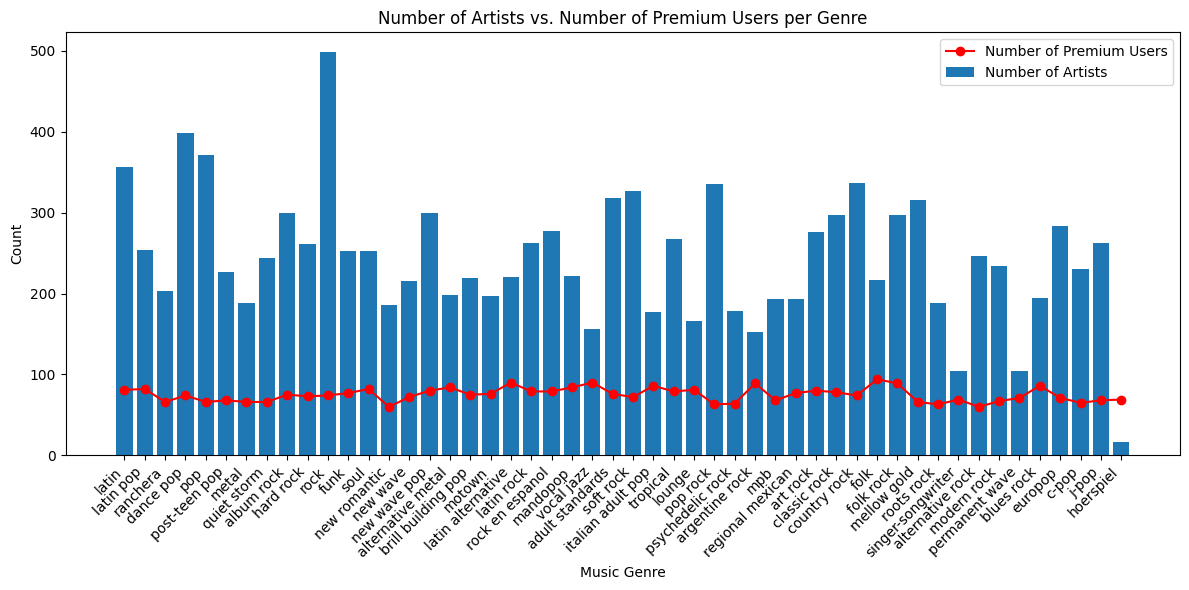

In [41]:
premium_users = [user_counter[genre][0] for genre in genres]
plt.figure(figsize=(12, 6))
plt.bar(genres, num_bands, label='Number of Artists')
plt.plot(genres, premium_users, marker='o', color='red', label='Number of Premium Users')

plt.xlabel('Music Genre')
plt.ylabel('Count')
plt.title('Number of Artists vs. Number of Premium Users per Genre')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

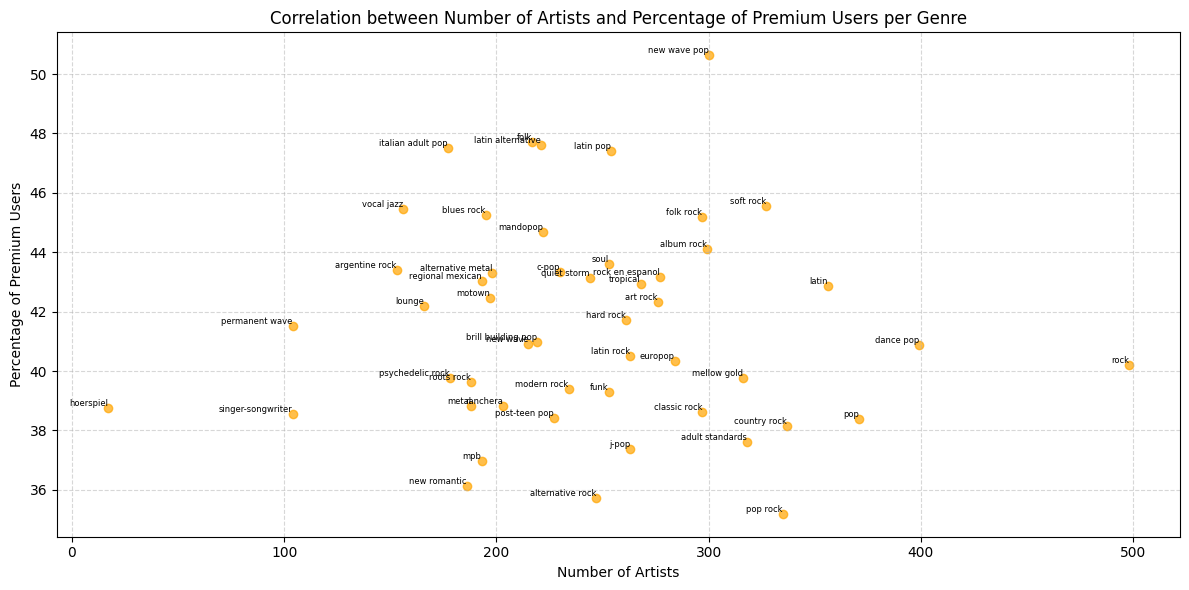

In [42]:
plt.figure(figsize=(12, 6))
plt.scatter(num_bands, premium_percentage, color='orange', alpha=0.7)

for i, genre in enumerate(genres):
    if genre in user_counter:
        plt.text(num_bands[i], premium_percentage[i], genre, fontsize=6, ha='right', va='bottom')

plt.xlabel('Number of Artists')
plt.ylabel('Percentage of Premium Users')
plt.title('Correlation between Number of Artists and Percentage of Premium Users per Genre')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [43]:
%pip install folium
%pip install geopy
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim

cities = {}
for user in users:
  city = user.get('city')
  if city not in cities:
    cities[city] = [cities.get(city, 0) + 1, 1 if user.get('premium_user') else 0]
  else:
    cities[city][0] += 1
    cities[city][1] += 1 if user.get('premium_user') else 0

geolocator = Nominatim(user_agent="geoapi")

locations = []
for city, users in cities.items():
    location = geolocator.geocode(city + ", Poland")
    if location:
        locations.append((location.latitude, location.longitude, users[0]))

m = folium.Map(location=[52.237049, 21.017532], zoom_start=6)  # Centrum Polski

heat_data = [(lat, lon, count) for lat, lon, count in locations]
HeatMap(heat_data).add_to(m)
# m.save("poland_heatmap.html")

m


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: C:\Users\asz-0\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: C:\Users\asz-0\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


<Figure size 1000x500 with 0 Axes>

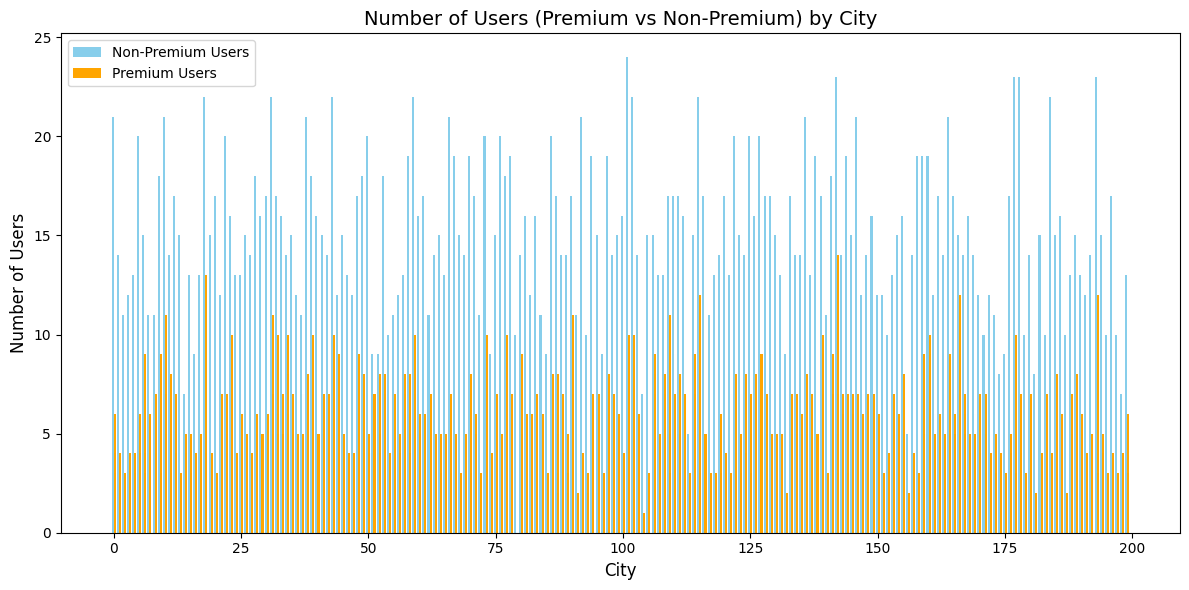

In [44]:
plt.figure(figsize=(10, 5))
keys = list(cities.keys())
values = [value[0] for value in cities.values()]
premium = [value[1] for value in cities.values()]


x = np.arange(len(keys))
bar_width = 0.4

plt.figure(figsize=(12, 6))
plt.bar(x - bar_width / 2, values, width=bar_width, color='skyblue', label='Non-Premium Users')
plt.bar(x + bar_width / 2, premium, width=bar_width, color='orange', label='Premium Users')
plt.xlabel('City', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.title('Number of Users (Premium vs Non-Premium) by City', fontsize=14)

# plt.xticks(x, keys, rotation=90, ha='right', fontsize=10)
plt.legend()

plt.tight_layout()
plt.show()
